#### Toxic Comment Classification Challenge

URL: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.insert(0, '../../Utils')
from helper import PlotLosses

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers
from keras.callbacks import ModelCheckpoint

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# AUC for a binary classifier
def auc(y_true, y_pred):   
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 30)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)    
    return FP/N
#-----------------------------------------------------------------------------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)    
    return TP/P

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
test_labels = pd.read_csv("./test_labels.csv")
submission = pd.read_csv("./sample_submission.csv")

In [4]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

## 1. Unigram

In [5]:
max_features = 10000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=max_features,
                                   stop_words='english')

tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)
dense_matrix_train = tfidf_matrix_train.todense()

tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)
dense_matrix_valid = tfidf_matrix_valid.todense()

--------
##### Entreno el modelo

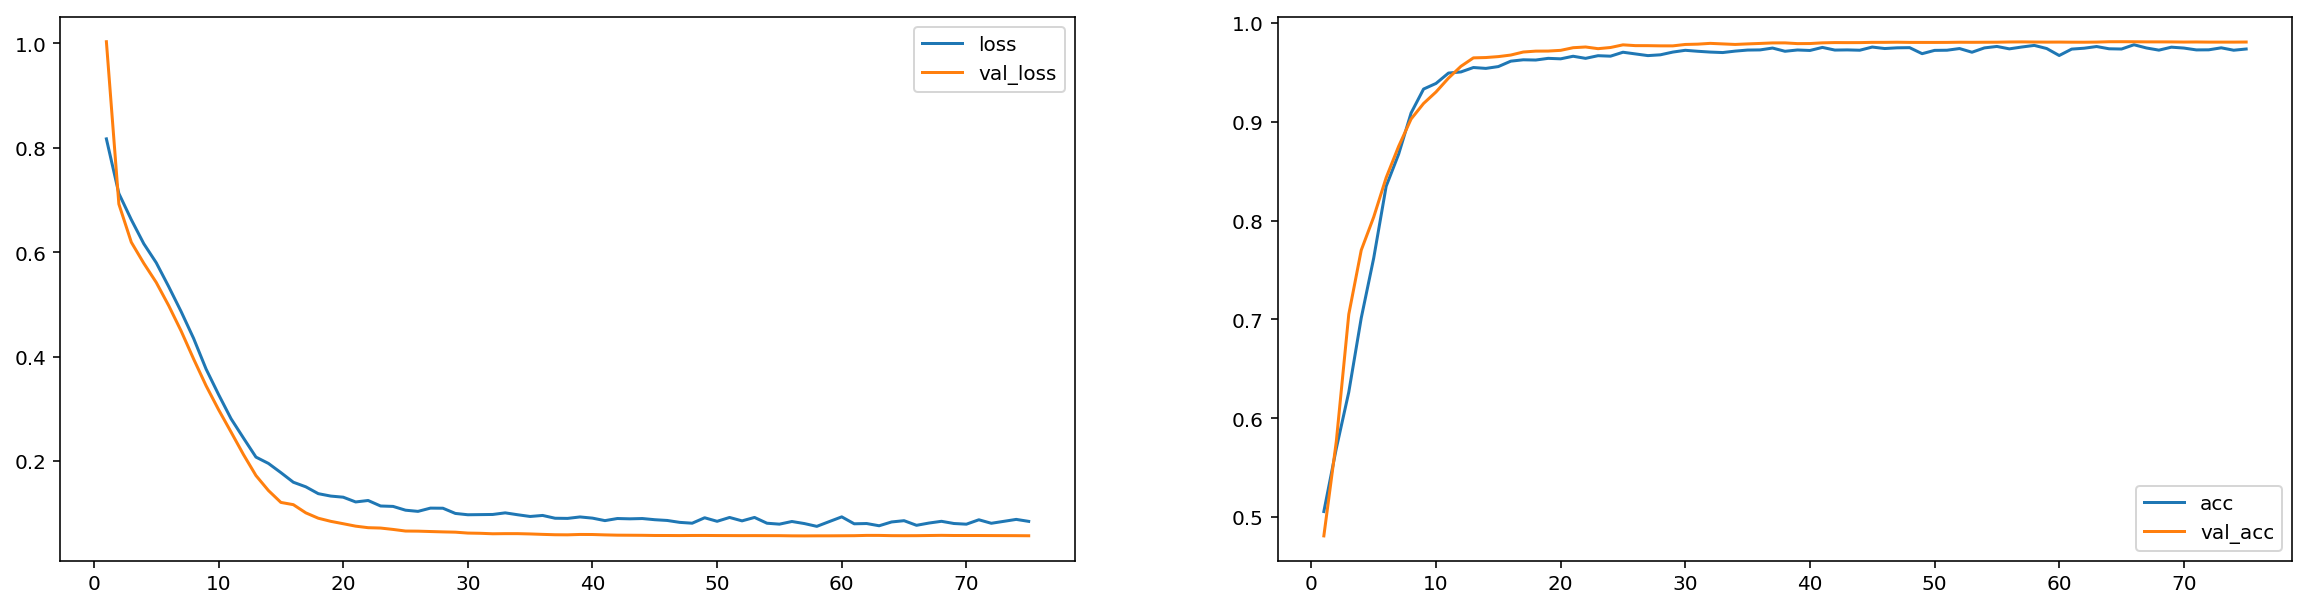


Epoch 00005: val_loss improved from 0.05704 to 0.05703, saving model to basic_model_best.hdf5


In [6]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]
hidden_units = 300
lambd = 0
dropout_rate = 0.5

model_sig_nn = Sequential()
#Capa oculta 1
model_sig_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), kernel_initializer="he_uniform", name="Capa_Oculta_1"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('elu', name="output_capa_oculta_1")) 
model_sig_nn.add(Dropout(dropout_rate))

#Capa oculta 2
model_sig_nn.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), kernel_initializer="he_uniform", name="Capa_Oculta_2"))
model_sig_nn.add(BatchNormalization())
model_sig_nn.add(Activation('elu', name="output_capa_oculta_2")) 
model_sig_nn.add(Dropout(dropout_rate))

#Capa de salida
model_sig_nn.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Salida"))
model_sig_nn.add(Activation('sigmoid', name="output2"))
model_sig_nn.summary()


lr = 0.01
batch_size = 2048
epochs = 5

selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, 
                     metrics=['accuracy']) #auc

checkpointer = ModelCheckpoint(filepath='basic_model_best.hdf5', verbose=1, save_best_only=True)

plot_losses = PlotLosses(plot_interval=1, 
                         evaluate_interval=5, 
                         x_val=dense_matrix_valid, 
                         y_val_categorical=Y_valid)
history = model_sig_nn.fit(dense_matrix_train, 
          Y_train, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=1, 
          validation_data=(dense_matrix_valid, Y_valid), 
          callbacks=[plot_losses, checkpointer],
         )

In [8]:
loss, acc = model_sig_nn.evaluate(dense_matrix_valid, Y_valid)
print("loss:", loss)
print("Accuracy:", acc)

15958/15958 [==============================] - 4s 259us/step
loss: 0.05702828786994546
Accuracy: 0.9807097790593535


---
##### Guardo resultados en archivo 

In [13]:
tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)
dense_matrix_test = tfidf_matrix_test.todense()
pred = model_sig_nn.predict(dense_matrix_test, verbose=1)
submission[list_classes] = pred
submission.to_csv("./submission.csv", index = False)

153164/153164 [==============================] - 62s 407us/step
